In [169]:
import pandas as pd
import wandb
from pathlib import Path
import numpy as np
import wandb
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from matplotlib.pyplot import MultipleLocator
api = wandb.Api(timeout=19)
mpl.rcParams["axes.unicode_minus"] = False

In [170]:
DroneEnv = {
    "Flock-4xagent": {
        # "MAJOR": [
        #     "fmxfranky/iclr22-drone-experiments/runs/1zgungx5",
        #     "fmxfranky/iclr22-drone-experiments/runs/2lvz9avu",
        #     "fmxfranky/iclr22-drone-experiments/runs/2hpj5s5o",
        #     "fmxfranky/iclr22-drone-experiments/runs/2jt2dh29",
        #     "fmxfranky/iclr22-drone-experiments/runs/3ln8i0k7",
        # ],
        "MAT": [
            "hlsong/drone_flock/6f515t5e",
            "hlsong/drone_flock/49dki36q",
            "hlsong/drone_flock/tbabd3ph",
            "hlsong/drone_flock/zqt3wabq",
            "hlsong/drone_flock/9pz6r54v",
            "hlsong/drone_flock/lhwte7je",
        ],
        "MASK_AGENT": [
            "hlsong/drone_flock/34l4scr8",
            "hlsong/drone_flock/7m83f190",
            "hlsong/drone_flock/ssm6oaoy",
            "hlsong/drone_flock/2yebjpm7",
        ],
        "MASK_AGENT_pro": [
            "hlsong/drone_flock/0sozqzjq",
            "hlsong/drone_flock/uhflgrpf",
            "hlsong/drone_flock/shit0ewx",
            "hlsong/drone_flock/h7ivvza2",
            "hlsong/drone_flock/4j1wcvho",
        ],
        # "HAPPO": [
        #     "fmxfranky/iclr22-drone-experiments/runs/26uq48wn",
        #     "fmxfranky/iclr22-drone-experiments/runs/2wzkf1b6",
        #     "fmxfranky/iclr22-drone-experiments/runs/3bdl5c6r",
        #     "fmxfranky/iclr22-drone-experiments/runs/3n7ighr7",
        #     "fmxfranky/iclr22-drone-experiments/runs/2w7h5m4m",
        # ],
        # "MAPPO": [
        #     "fmxfranky/iclr22-drone-experiments/runs/3jehsypw",
        #     "fmxfranky/iclr22-drone-experiments/runs/1hjupjzo",
        #     "fmxfranky/iclr22-drone-experiments/runs/av98mdws",
        #     "fmxfranky/iclr22-drone-experiments/runs/10haayxs",
        #     "fmxfranky/iclr22-drone-experiments/runs/2sfaww43",
        # ],
    },
    "LeaderFollower-4xagent": {
        "MAT": [
            "hlsong/drone_flock/6f515t5e",
            "hlsong/drone_flock/49dki36q",
            "hlsong/drone_flock/tbabd3ph",
            "hlsong/drone_flock/zqt3wabq",
            "hlsong/drone_flock/9pz6r54v",
            "hlsong/drone_flock/lhwte7je",
        ],
        "MASK_AGENT": [
            "hlsong/drone_flock/34l4scr8",
            "hlsong/drone_flock/7m83f190",
            "hlsong/drone_flock/ssm6oaoy",
            "hlsong/drone_flock/2yebjpm7",
        ],
        "MASK_AGENT_pro": [
            "hlsong/drone_flock/0sozqzjq",
            "hlsong/drone_flock/uhflgrpf",
            "hlsong/drone_flock/shit0ewx",
            "hlsong/drone_flock/h7ivvza2",
            "hlsong/drone_flock/4j1wcvho",
        ],
    },
    "Meetup-4xagent": {
        "MAT": [
            "hlsong/drone_flock/6f515t5e",
            "hlsong/drone_flock/49dki36q",
            "hlsong/drone_flock/tbabd3ph",
            "hlsong/drone_flock/zqt3wabq",
            "hlsong/drone_flock/9pz6r54v",
            "hlsong/drone_flock/lhwte7je",
        ],
        "MASK_AGENT": [
            "hlsong/drone_flock/34l4scr8",
            "hlsong/drone_flock/7m83f190",
            "hlsong/drone_flock/ssm6oaoy",
            "hlsong/drone_flock/2yebjpm7",
        ],
        "MASK_AGENT_pro": [
            "hlsong/drone_flock/0sozqzjq",
            "hlsong/drone_flock/uhflgrpf",
            "hlsong/drone_flock/shit0ewx",
            "hlsong/drone_flock/h7ivvza2",
            "hlsong/drone_flock/4j1wcvho",
        ],
    },
}
env_list={"drone":DroneEnv}

In [171]:
def get_df_from_wandb( env, scenario, store=True,smooth=1,smooth_method =2,step_lenth=None):
    df_list = []
    print(f" - scenario:{scenario}")
    for algo in env[scenario].keys():
        print(f"  -- algo:{algo}")
        curve_list = []
        for run_name in env[scenario][algo]:
            run = api.run(run_name)
            config = {k: v for k, v in run.config.items() if not k.startswith("_")}
            print(f"   --- {run.name}")
            if config["env_name"] == "mujoco":
                metric_key = (
                    "eval_average_episode_rewards"
                    if algo == "HAPPO"
                    else "faulty_node_-1/eval_average_episode_rewards"
                )
            elif config["env_name"] == "drone":
                metric_key = "eval_average_episode_rewards"
            elif config["env_name"] == "football":
                metric_key = "eval_average_episode_scores"
            else:
                metric_key = "eval_win_rate"
            history = run.history().dropna()[["_step", metric_key]]
            history["algorithm"] = algo
            history["seed"] = config["seed"]
            history["Environment steps"] = history["_step"]
            history["Reward"] = history[metric_key]
            indicator = "Reward"
            curve_list.append(history)
            # store the data
            if store ==True:
                env_name = run.config['env_name']
                if env_name is not None :
                    if env_name == 'drone':
                        dir_name = Path.cwd() / env_name / scenario / algo
                    elif env_name == 'mujoco':
                        map_name = f"{map_name}-{run.config['agent_conf']}"
                        dir_name = Path.cwd() / env_name / scenario / algo
                Path.mkdir(dir_name, parents=True, exist_ok=True)
                file_name = dir_name / f"{run.name}.csv"
                history.to_csv(file_name)

            # smooth the data
            if smooth_method == 1 and smooth > 1:
                history["Smooth_Reward"] = history[metric_key].rolling(smooth, min_periods=1).mean()
                indicator = "Smooth_Reward"
            elif smooth_method == 2 and smooth > 1:
                y = np.ones(smooth)
                x = np.asarray(history["Reward"])  # (200, 1)
                x = np.squeeze(x)  # (200,)
                z = np.ones(len(x))
                smoothed_x = np.convolve(x, y, 'same') / np.convolve(z, y, 'same')
                history["Smooth_Reward"] = smoothed_x
                indicator = "Smooth_Reward"
        data = pd.concat(curve_list)
        data.reset_index(drop=True, inplace=True)
        df_list.append(data)
    df = pd.concat(df_list)
    df.reset_index(drop=True, inplace=True)
    if step_lenth is not None:
        df = df[df["_step"] < step_lenth]
    return df , indicator

In [172]:
def get_df_from_local(env_name, scenario, path, smooth=1, smooth_method=2, step_lenth=None,):
    if Path(path).is_absolute():
        data_path = Path(path)
    else:
        data_path = Path.cwd() / path
    logdir = data_path / env_name / scenario
    df_list = []
    print(f" - scenario:{scenario}")
    for data_dir in logdir.iterdir():
        if data_dir.is_dir():
            algo = data_dir.parts[-1]
            print(f"  -- algo:{algo}")
            curve_list = []
            for file in data_dir.rglob('*.csv'):
                print(f"   --- {file}")
                data = pd.read_csv(file)
                # smooth the data
                if smooth_method == 1 and smooth > 1:
                    data["Smooth_Reward"] = data["Reward"].rolling(smooth, min_periods=1).mean()
                    indicator = "Smooth_Reward"
                elif smooth_method == 2 and smooth > 1:
                    y = np.ones(smooth)
                    x = np.asarray(data["Reward"])  # (200, 1)
                    x = np.squeeze(x)  # (200,)
                    z = np.ones(len(x))
                    smoothed_x = np.convolve(x, y, 'same') / np.convolve(z, y, 'same')
                    data["Smooth_Reward"] = smoothed_x
                    indicator = "Smooth_Reward"
                curve_list.append(data)
            data = pd.concat(curve_list)
            data.reset_index(drop=True, inplace=True)
            df_list.append(data)
        df = pd.concat(df_list)
        df.reset_index(drop=True, inplace=True)
        if step_lenth is not None:
            df = df[df["_step"] < step_lenth]
    return df, indicator


In [173]:
def plot_one_scenario(df, indicator, env_name, scenario, save=False):
    sns.set_theme(
        style="darkgrid",
        font_scale=2,
        rc={"lines.linewidth": 3},
        # font="Tlwg Mono",
        color_codes=True,
    )
    colors = [
        sns.color_palette("husl", 9)[0],
        sns.color_palette("husl", 9)[6],
        sns.color_palette("husl", 9)[7],
        # sns.color_palette("husl", 9)[5],
    ]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 10))
    ax.set_title(scenario, fontsize=25)
    sns.lineplot(
        data=df, x="Environment steps", y=indicator, hue="algorithm", palette=colors ,ax=ax
    )
    ax.set_xlabel("Environment steps", labelpad=10)
    ax.set_ylabel("Reward", labelpad=10)
    # ax.xaxis.set_major_locator(MultipleLocator(250000))
    # plt.xlabel("Environment steps", fontsize=30)
    # plt.ylabel("Reward", fontsize=30)
    ax.legend(fontsize=20,loc='best')
    # plt.legend(fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    if save == True:
        plt.savefig(f"{env_name}-{scenario}.pdf")
    plt.show()

In [174]:
def plot_multi_scenario(env_name, scenarioes, nsize, save=False, dfargs=None):
    assert nsize[0] * nsize[1] == len(scenarioes)
    sns.set_theme(
        style="darkgrid",
        font_scale=2,
        rc={"lines.linewidth": 3},
        # font="Tlwg Mono",
        color_codes=True,
    )
    colors = [
        sns.color_palette("husl", 9)[0],
        sns.color_palette("husl", 9)[6],
        sns.color_palette("husl", 9)[7],
        # sns.color_palette("husl", 9)[5],
    ]
    fig, axis = plt.subplots(nrows=nsize[0], ncols=nsize[1], figsize=(14*nsize[1], 10*nsize[0]*1.1))

    for i in range(len(scenarioes)):
        scenario = scenarioes[i]
        if dfargs["from_wandb"]:
            df, indicator = get_df_from_wandb(dfargs["env"], scenario, dfargs["store"],dfargs["smooth"], dfargs["smooth_method"], dfargs["step_lenth"])
        else:
            df, indicator = get_df_from_local(env_name, scenario, dfargs["path"], dfargs["smooth"], dfargs["smooth_method"], dfargs["step_lenth"])

        if len(axis.shape)>1:
            ax = axis[i // nsize[1], i % nsize[1]]
        else:
            ax = axis[i]
        ax.set_title(scenario, fontsize=25)
        sns.lineplot(
            data=df, x="Environment steps", y=indicator, hue="algorithm", palette=colors, ax=ax
        )
        ax.set_xlabel('')
        ax.set_ylabel('')
        # ax.xaxis.set_major_locator(MultipleLocator(250000))
        ax.legend(fontsize=20, loc='best')
    # set labels
    if len(axis.shape) > 1:
        for ax in axis[-1, :]:
            ax.set_xlabel('Environment steps', labelpad=10)
        for ax in axis[:, 0]:
            ax.set_ylabel('Reward', labelpad=10)
    else:
        for ax in axis:
            ax.set_xlabel('Environment steps', labelpad=10)
        axis[0].set_ylabel('Reward', labelpad=10)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    if save == True:
        plt.savefig(f"{env_name}.pdf")
    plt.show()

env: drone
 - scenario:Flock-4xagent
  -- algo:MAT
   --- mat_drone_flock_seed2183_1029-0959-baseline
   --- mat_drone_flock_seed1367_1026-1457-baseline
   --- mat_drone_flock_seed6887_1029-0900-baseline
   --- mat_drone_flock_seed2254_1103-1014
   --- mat_drone_flock_seed4797_1104-0448
   --- mat_drone_flock_seed7203_1104-0450
  -- algo:MASK_AGENT
   --- mask_drone_flock_seed6286_1103-1547
   --- mask_drone_flock_seed2104_1102-1831-good
   --- mask_drone_flock_seed1036_1102-1824
   --- mask_drone_flock_seed5683_1102-1523-good
  -- algo:MASK_AGENT_pro
   --- mask_drone_flock_seed2113_1107-0534
   --- mask_drone_flock_seed7704_1106-1933
   --- mask_drone_flock_seed6237_1106-1127
   --- mask_drone_flock_seed9100_1106-0106
   --- mask_drone_flock_seed7767_1106-0019
 - scenario:LeaderFollower-4xagent
  -- algo:MAT
   --- mat_drone_flock_seed2183_1029-0959-baseline
   --- mat_drone_flock_seed1367_1026-1457-baseline
   --- mat_drone_flock_seed6887_1029-0900-baseline
   --- mat_drone_flock_se

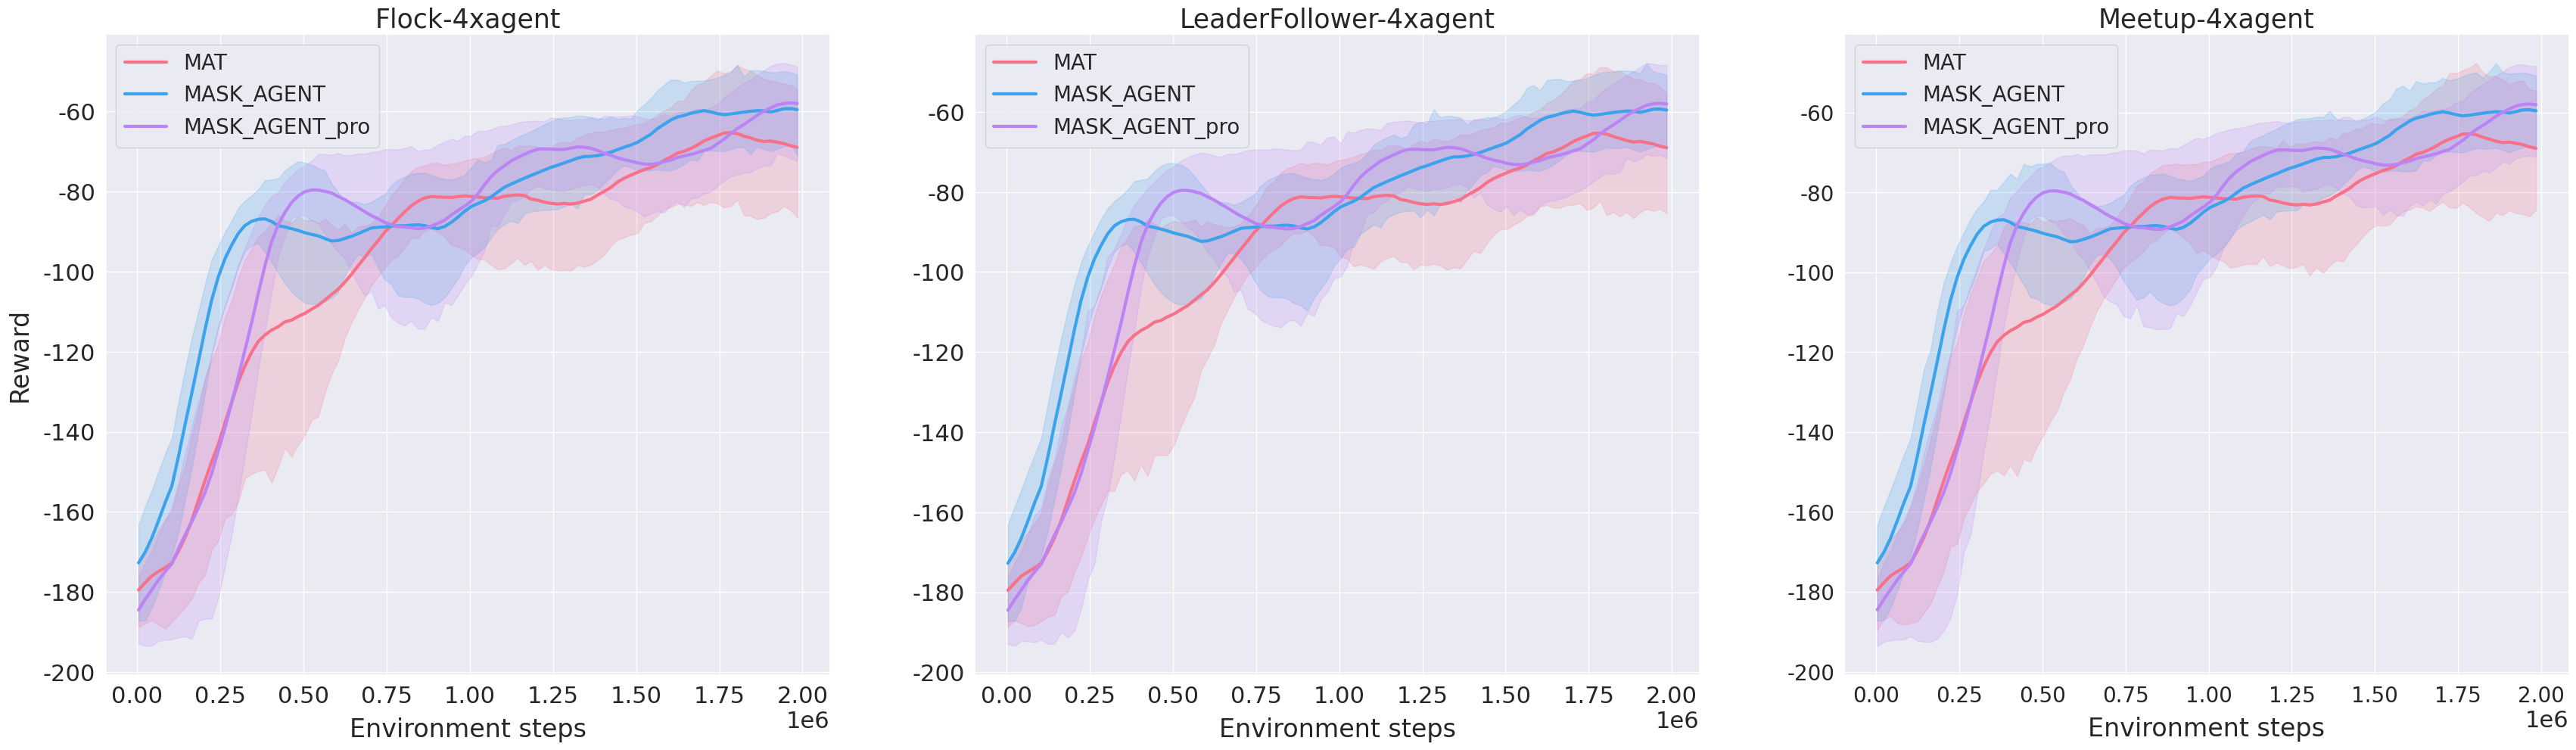

In [175]:
env_name = "drone"
env = env_list[env_name]
scenario = "Flock-4xagent"
scenarios = [key for key in env.keys()]
store = True
path = './'
step_lenth = None
smooth = 10
smooth_method = 2
dfargs = {
    "env_name": env_name,
    "env": env,
    "scenario": scenario,
    "scenarios": scenarios,
    "store": store,
    "path": path,
    "step_lenth": step_lenth,
    "smooth": smooth,
    "smooth_method": smooth_method,
    "from_wandb" : True,
}
# for scenario in scenarios:
#     print(f"env: {env_name}")
#     df, indicator = get_df_from_wandb(env, scenario, store, smooth, smooth_method, step_lenth)
#     plot_one_scenario(df, indicator, env_name, scenario, save=True)
print(f"env: {env_name}")
plot_multi_scenario(env_name, scenarios, nsize=(1, 3), save=True, dfargs=dfargs)